In [2]:
!pip install sidrapy

In [3]:
import sidrapy as sidra
from bcb import sgs
import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from great_tables import GT, md, html, style, loc

# Coleta de Dados

In [12]:
colors = {'blue': '#282f6b',
          'yellow': '#eace3f',
          'red'   : "#b22200",
          'green': '#224f20',
          'purple' : "#5f487c",
          'gray': '#666666',
          'orange' : '#b35c1e',
          'turquoise' : "#419391",
          'green_two' : "#839c56"
          }

In [4]:
## Coleta dos dados
# PIB e seus componentes
dados_pib_brutos = list(
    map(
        # função com 2 argumentos que será repetida
        lambda tabela, variavel: ( # lambda argumento1, argumento2: função/expressão a ser executada
            sidra.get_table(
                table_code = tabela,
                territorial_level = "1", # alguns argumentos recebem valores padrão
                ibge_territorial_code = "all",
                variable = variavel,
                classifications = { # PIB preços mercado e componentes (óticas)
                    "11255": "90687,90691,90696,90707,93404,93405,93406,93407,93408"
                    },
                period = "all"
                )
            ),

        # códigos das tabelas (pro argumento tabela)
        ["1620", "1621"],

        # códigos da variável dentro da tabela (pro argumento variavel)
        ["583", "584"]
        )
    ) # lista de DataFrame

# PMC ampliado
pmc_brutos = sidra.get_table(
                table_code = 8881,
                territorial_level = "1", # alguns argumentos recebem valores padrão
                ibge_territorial_code = "all",
                variable = '7170,11708,11709,11711',
                classifications = {"11046" : "56736"},
                period = "all",
                header = 'n'
                )

# PMS
pms_brutos = sidra.get_table(
                table_code = 5906,
                territorial_level = "1", # alguns argumentos recebem valores padrão
                ibge_territorial_code = "all",
                variable = '7168,11623,11624,11626',
                period = "all",
                classifications = {"11046" : "56726"},
                header = 'n'
                )

# PIM-PF
pim_brutos = sidra.get_table(
                table_code = 8888,
                territorial_level = "1", # alguns argumentos recebem valores padrão
                ibge_territorial_code = "all",
                variable = '11601,11602,11604, 12607',
                period = "all",
                classifications = {"544" : "129314"},
                header = 'n'
                )

# IBC-Br
ibc_brutos = sgs.get({"ibc" : 24363, "ibc_sa" : 24364}, start = "2003-01-27")

In [5]:
### Tratamento de dados do PIB
dados_pib = (
    pd.concat(  # empilha em uma tabela todos os DataFrames
        objs = dados_pib_brutos,
        keys = ["num_indice", "num_indice_sa", "precos_correntes",
                "precos_constantes", "precos_constantes_sa"],
        names = ["tabela", "linha"]
        )
    .reset_index()
    .rename(columns = dados_pib_brutos[0].iloc[0])
    # filtra na coluna Trimestre tudo que não for igual a "Trimestre" (cabeçalho)
    .query("Trimestre not in 'Trimestre'")
    .rename(
        columns = {
            "Trimestre (Código)": "data",
            "Setores e subsetores": "rubrica",
            "Valor": "valor"
            }
            )
    .filter(items = ["tabela", "data", "rubrica", "valor"], axis = "columns")
    .replace( # recodifica valores da coluna rubrica
        to_replace = {
            "rubrica": {
                "Agropecuária - total": "Agropecuária",
                "Indústria - total": "Indústria",
                "Serviços - total": "Serviços",
                "PIB a preços de mercado": "PIB",
                "Despesa de consumo das famílias": "Consumo das Famílias",
                "Despesa de consumo da administração pública": "Despesa do Governo",
                "Formação bruta de capital fixo": "FBFC",
                "Exportação de bens e serviços": "Exportação",
                "Importação de bens e serviços (-)": "Importação"
                }
                }
             )
    .assign(  # substitui o 5º caracter da coluna data por "-Q" e converte em YYYY-MM-DD
        data = lambda x: pd.to_datetime(
            x.data.str.slice_replace(start = 4, stop = 5, repl = "-Q")
            ),
        valor = lambda x: x.valor.astype(float) # converte de texto para numérico
        )
    )

# Calculando taxas de variação
## Realiza a manipulação dos dados
taxas_pib = (
    dados_pib.query("tabela in ['num_indice', 'num_indice_sa']")
    .pivot(index = ["data", "rubrica"], columns = "tabela", values = "valor")
    .reset_index()
    .sort_values("data") # ordena ascedentemente pela coluna data
    )

# Utiliza o método assign para criar novas colunas no DataFrame taxas_pib
taxas_pib = (
    taxas_pib.assign(
        # Calcula a Variação Marginal por grupo (rubrica), usando pct_change(1) para calcular a variação percentual em relação ao período anterior
        var_margem=lambda x: x.groupby("rubrica", group_keys=False)["num_indice_sa"]
                              .apply(lambda y: y.pct_change(1) * 100),
        
        # Calcula a Variação Interanual por grupo (rubrica), usando pct_change(4) para calcular a variação percentual em relação ao mesmo período do ano anterior
        var_interanual=lambda x: x.groupby("rubrica", group_keys=False)["num_indice"]
                                  .apply(lambda y: y.pct_change(4) * 100),
        
        # Calcula a Variação Anual por grupo (rubrica), usando rolling(4) para calcular a soma móvel de 4 períodos e calcular a variação percentual em relação ao mesmo período do ano anterior
        var_anual=lambda x: x.groupby("rubrica", group_keys=False)["num_indice"]
                             .apply(lambda y: (y.rolling(4).sum() / y.rolling(4).sum().shift(4) - 1) * 100),
    )
)

# Renomeando as colunas
taxas_pib = taxas_pib.rename(columns = {
        "var_margem": "Var. % margem",
        "var_interanual": "Var. % interanual",
         "var_anual": "Var. % anual",
         "num_indice" : "Número Índice",
         "num_indice_sa" : "Número Índice S.A."
         }
      )

C:\Users\pedro\AppData\Local\Temp\ipykernel_38828\398285060.py:3: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
C:\Users\pedro\AppData\Local\Temp\ipykernel_38828\398285060.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [6]:
# Tratamento das pesquisas
# Realiza o tratamento da PMC
pmc =  (
  pmc_brutos
  .loc[1:,['V', 'D2C', 'D3N']]
  .rename(columns = {'V': 'valor',
                     'D2C': 'data',
                     'D3N': 'variable'})
  .query('valor not in "..."') # filtra para somente valores numéricos
    .assign(
        data = lambda x: pd.to_datetime(x['data'], format = "%Y%m"), # passa para datetime
        valor = lambda x: x.valor.astype(float) # converte de texto para numérico
    )
    .replace( # recodifica valores da coluna rubrica
        to_replace = {
            "variable": {
              "PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)": "Var. % margem",
              "PMC - Variação mês/mesmo mês do ano anterior (M/M-12)": "Var. % interanual",
              "PMC - Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)": "Var. % acumulada em 12 meses",
              "PMC - Número-índice com ajuste sazonal (2022=100)" : "Número Índice S.A."
            }
           }
        )
       )
       
# Realiza o tratamento da PMS       
pms =  (
  pms_brutos
  .loc[1:,['V', 'D2C', 'D3N']]
  .rename(columns = {'V': 'valor',
                     'D2C': 'data',
                     'D3N': 'variable'})
  .query('valor not in "..."') # filtra para somente valores numéricos
    .assign(
        data = lambda x: pd.to_datetime(x['data'], format = "%Y%m"), # passa para datetime
        valor = lambda x: x.valor.astype(float) # converte de texto para numérico
    )
    .replace( # recodifica valores da coluna rubrica
        to_replace = {
            "variable": {
              "PMS - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)": "Var. % margem",
              "PMS - Variação mês/mesmo mês do ano anterior (M/M-12)": "Var. % interanual",
              "PMS - Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)": "Var. % acumulada em 12 meses",
              "PMS - Número-índice com ajuste sazonal (2022=100)" : "Número Índice S.A."
            }
           }
        )
       )
  
       
# Realiza o tratamento da PIM-PF (ind. geral)
pim = (
  pim_brutos
  .loc[1:,['V', 'D2C', 'D3N']]
  .rename(columns = {'V': 'valor',
                     'D2C': 'data',
                     'D3N': 'variable'})
  .query('valor not in "..."') # filtra para somente valores numéricos
    .assign(
        data = lambda x: pd.to_datetime(x['data'], format = "%Y%m"), # passa para datetime
        valor = lambda x: x.valor.astype(float) # converte de texto para numérico
    )
    .replace( # recodifica valores da coluna rubrica
        to_replace = {
            "variable": {
              "PIMPF - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1)": "Var. % margem",
              "PIMPF - Variação mês/mesmo mês do ano anterior (M/M-12)": "Var. % interanual",
              "PIMPF - Variação acumulada em 12 meses (em relação ao período anterior de 12 meses)": "Var. % acumulada em 12 meses",
              "PIMPF - Número-índice com ajuste sazonal (2022=100)" : "Número Índice S.A."
            }
           }
        )
       )

In [7]:
# Realiza o tratamento dos dados do IBC-br
taxas_ibc = (
        ibc_brutos
        .reset_index()
        .assign(
        # Calcula as variações
        var_margem =lambda x: x["ibc_sa"].pct_change(1) * 100,
        var_interanual=lambda x: x["ibc"].pct_change(4) * 100,
        var_anual=lambda x: (x["ibc"].rolling(4).sum() / x['ibc'].rolling(4).sum().shift(4) - 1) * 100
       )
       .drop('ibc', axis = 1)
       )

# Renomeia as colunas
taxas_ibc.columns = ['data', "Número Índice S.A.", "Var. % margem", "Var. % interanual", "Var. % acumulada em 12 meses"]

# Transforma dados do IBC-br em long
taxas_ibc_long = taxas_ibc.melt(id_vars = 'data', value_name = 'valor')

# Junta as pesquisas
pesquisas = (pd.concat([pms, pmc, pim, taxas_ibc_long], keys=['PMS', 'PMC Ampliado', 'PIM-PF (Ind. Geral)', 'IBC-br'], names=['Pesquisa'])
              .reset_index()
              .drop('level_1', axis = 1)
              )

In [8]:
# Realiza manipulação para a tabela
taxas_pib_resumo = (
  taxas_pib
 .query('rubrica == "PIB"')
 .drop(['rubrica', 'Número Índice', 'Número Índice S.A.'], axis = 1)
 .rename_axis(None, axis=1)
 .tail(8)
 .sort_values('data', ascending = False)
 )
 
# Cria a tabela
(GT(taxas_pib_resumo, rowname_col = 'data')
.tab_header(title = 'Variações do PIB')
.fmt_date(columns = 'data', date_style = 'year_quarter')
.fmt_percent(columns = ['Var. % margem',
                        'Var. % interanual',
                         'Var. % anual'],
                         scale_values = False,
                         dec_mark = ',',
                         sep_mark = '.'
                         )).opt_all_caps(locations = 'column_labels')

GT(_tbl_data=           data  Var. % margem  Var. % interanual  Var. % anual
1006 2023-10-01      -0.032619           2.048699      2.907932
997  2023-07-01       0.032630           1.961320      3.072792
988  2023-04-01       0.839046           3.471400      3.676134
979  2023-01-01       1.322443           4.218434      3.695323
970  2022-10-01       0.183701           2.696022      3.017372
961  2022-07-01       0.921348           4.320073      2.710393
952  2022-04-01       1.303284           3.541837      2.666706
943  2022-01-01       0.924756           1.477746      4.678354, _body=<great_tables._gt_data.Body object at 0x000002AC4A3F9850>, _boxhead=Boxhead([ColInfo(var='data', type=<ColInfoTypeEnum.stub: 2>, column_label='data', column_align='right', column_width=None), ColInfo(var='Var. % margem', type=<ColInfoTypeEnum.default: 1>, column_label='Var. % margem', column_align='right', column_width=None), ColInfo(var='Var. % interanual', type=<ColInfoTypeEnum.default: 1>, column_label='Var. % interanual', column_align='right', column_width=None), ColInfo(var='Var. % anual', type=<ColInfoTypeEnum.default: 1>, column_label='Var. % anual', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=Timestamp('2023-10-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=Timestamp('2023-07-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=Timestamp('2023-04-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=Timestamp('2023-01-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=Timestamp('2022-10-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=Timestamp('2022-07-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=Timestamp('2022-04-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=Timestamp('2022-01-01 00:00:00'), group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title='Variações do PIB', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002AC48FE8DD0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002AC48FE9090>, <great_tables._gt_data.FormatInfo object at 0x000002AC4A38C310>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', val

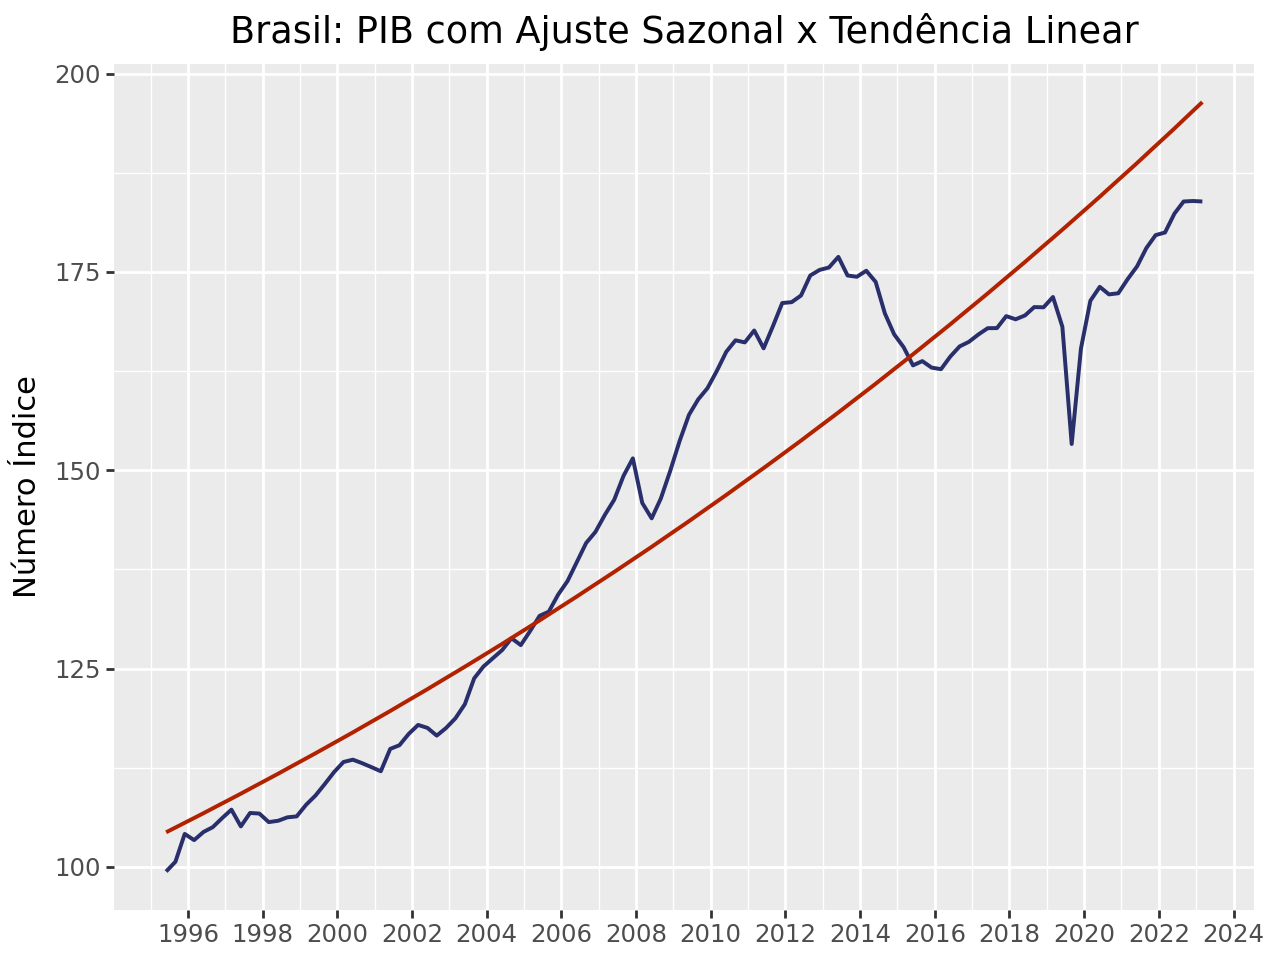

In [9]:
# Realiza tratamento para criar o gráfico
num_ind_pib = (
    taxas_pib.query("rubrica == 'PIB'")
    .filter(
        items = ["data", "Número Índice S.A."],
        axis = "columns"
        )
        .reset_index(drop = True)
   )
   
# Cria novas colunas auxiliares para o exercício
num_ind_pib["ln_pib"] = np.log(num_ind_pib["Número Índice S.A."])  # Transformação logarítmica do PIB
num_ind_pib["tempo"] = num_ind_pib.index + 1        # Vetor de 1 até T indicando ordenação tempora das observações
   
# Regressão linear do PIB contra o tempo
reg1 = smf.ols(
    formula = "ln_pib ~ tempo",  # especificação do modelo no formato de fórmula
    data = num_ind_pib  # fonte dos dados
    ).fit() # estima o modelo

# Salva a tendência estimada
num_ind_pib['Tendência Linear'] = np.exp(reg1.predict()) # extrai os valores estimados e reverte a transformação logarítmica

# Cria o gráfico do número índice do PIB
(
    ggplot(num_ind_pib, aes(x='data')) +
    geom_line(aes(y='Número Índice S.A.'), color = "#282f6b", size=0.8) +
    geom_line(aes(y='Tendência Linear'), color = "#b22200", size=0.8) +
    scale_x_date(date_breaks = "24 month", date_labels = "%Y") +
    labs(
        x="",
        y="Número Índice",
        title="Brasil: PIB com Ajuste Sazonal x Tendência Linear")
    )

# PIB e seus componentes

In [26]:
# Cria função para auxiliar na criação da tabela
def pivot_componentes(dados, variacao, n = 8, nome = 'Var % Interanual'):
    tabela = (dados
                  [["data", variacao, 'rubrica']]
                  .pivot_table(index='data', columns='rubrica', values=variacao)
                  .reset_index()
                  .tail(n)
                  .sort_values('data', ascending = False)
                 )

    resultado = (GT(tabela, rowname_col = 'data')
                .tab_header(title = md(f'**Variações dos Componentes do PIB** <br> {nome}'))
                .cols_move(columns = ['Consumo das Famílias',
                                        'Despesa do Governo',
                                        'FBFC',
                                        'Exportação',
                                        'Importação',
                                        'Indústria',
                                        'Agropecuária',
                                        'Serviços'
                                        ],
                                        after = 'PIB')
                .fmt_date(columns = 'data', date_style = 'year_quarter')
                .fmt_percent(columns = ['Consumo das Famílias',
                                        'Despesa do Governo',
                                        'FBFC',
                                        'Exportação',
                                        'Importação',
                                        'Indústria',
                                        'Agropecuária',
                                        'Serviços',
                                        'PIB'],
                                        scale_values = False,
                                        dec_mark = ',',
                                        sep_mark = '.'
                                        )).opt_all_caps(locations = 'column_labels')
    return resultado

# Cria tabela de variação marginal
pivot_componentes(taxas_pib, variacao = "Var. % margem", nome = "Variação contra Trimestre Anterior")

GT(_tbl_data=rubrica       data  Agropecuária  Consumo das Famílias  Despesa do Governo  \
110     2023-10-01     -5.322838             -0.209719            0.879007   
109     2023-07-01     -5.574362              0.871988            0.637440   
108     2023-04-01     -6.447282              0.974263            1.091531   
107     2023-01-01     20.924908              0.713611            0.442507   
106     2022-10-01      1.792297              0.580536           -1.457859   
105     2022-07-01      3.535863              0.696179            2.262895   
104     2022-04-01     -2.581307              2.005746           -0.588858   
103     2022-01-01     -5.428017              1.307046            0.052959   

rubrica  Exportação      FBFC  Importação  Indústria       PIB  Serviços  
110        0.145153  0.919696    0.942522   1.280944 -0.032619  0.347781  
109        2.762278 -2.161966   -2.135864   0.637312  0.032630  0.322866  
108        3.620803 -0.204906    4.067823   1.024290  0.839046  0.660481  
107        0.538129 -2.976260   -3.540528   0.014635  1.322443  0.617089  
106        4.697056 -1.605201   -4.608145  -0.733638  0.183701  0.100311  
105        3.125680  3.010727    5.073980   0.658039  0.921348  1.267109  
104       -3.417957  3.274575    5.982182   1.544287  1.303284  1.310801  
103        9.395312 -1.507114   -2.507369   3.242373  0.924756  0.956964  , _body=<great_tables._gt_data.Body object at 0x000002AC4D65A750>, _boxhead=Boxhead([ColInfo(var='data', type=<ColInfoTypeEnum.stub: 2>, column_label='data', column_align='right', column_width=None), ColInfo(var='PIB', type=<ColInfoTypeEnum.default: 1>, column_label='PIB', column_align='right', column_width=None), ColInfo(var='Consumo das Famílias', type=<ColInfoTypeEnum.default: 1>, column_label='Consumo das Famílias', column_align='right', column_width=None), ColInfo(var='Despesa do Governo', type=<ColInfoTypeEnum.default: 1>, column_label='Despesa do Governo', column_align='right', column_width=None), ColInfo(var='FBFC', type=<ColInfoTypeEnum.default: 1>, column_label='FBFC', column_align='right', column_width=None), ColInfo(var='Exportação', type=<ColInfoTypeEnum.default: 1>, column_label='Exportação', column_align='right', column_width=None), ColInfo(var='Importação', type=<ColInfoTypeEnum.default: 1>, column_label='Importação', column_align='right', column_width=None), ColInfo(var='Indústria', type=<ColInfoTypeEnum.default: 1>, column_label='Indústria', column_align='right', column_width=None), ColInfo(var='Agropecuária', type=<ColInfoTypeEnum.default: 1>, column_label='Agropecuária', column_align='right', column_width=None), ColInfo(var='Serviços', type=<ColInfoTypeEnum.default: 1>, column_label='Serviços', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=Timestamp('2023-10-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=Timestamp('2023-07-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=Timestamp('2023-04-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=Timestamp('2023-01-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=Timestamp('2022-10-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=Timestamp('2022-07-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=Timestamp('2022-04-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=Timestamp('2022-01-01 00:00:00'), group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title=Text(text='**Variações dos Componentes do PIB** <br> Variação contra Trimestre Anterior', type='from_markdown'), subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 

# Componentes PIB

In [27]:
# Cria tabela de variação interanual
pivot_componentes(taxas_pib, "Var. % interanual", nome = "Variação Interanual")

GT(_tbl_data=rubrica       data  Agropecuária  Consumo das Famílias  Despesa do Governo  \
107     2023-10-01     -0.025717              2.284444            3.002443   
106     2023-07-01      8.770846              3.266674            0.770127   
105     2023-04-01     20.941515              3.064656            2.260410   
104     2023-01-01     22.942989              3.951249            0.578592   
103     2022-10-01     -3.732128              4.593752            0.257832   
102     2022-07-01      8.824659              4.754593            2.650634   
101     2022-04-01     -0.920084              5.475142            1.830664   
100     2022-01-01     -6.638012              1.726676            4.019488   

rubrica  Exportação      FBFC  Importação  Indústria       PIB  Serviços  
107        7.322188 -4.379100   -0.902868   2.895274  2.048699  1.883579  
106        9.989358 -6.764229   -6.139002   0.965479  1.961320  1.794818  
105       11.882711 -1.779338    1.197416   1.021308  3.471400  2.713807  
104        7.130908  1.443817    1.836304   1.524699  4.218434  3.257908  
103       11.965077  3.225423    3.595661   4.607873  2.696022  3.581356  
102        8.119791  5.070720   10.932713   2.637770  4.320073  4.969419  
101       -4.083891  2.000123   -0.039373   1.084373  3.541837  4.733326  
100        8.657068 -5.912232  -10.235373  -2.302782  1.477746  3.749207  , _body=<great_tables._gt_data.Body object at 0x000002AC4D627750>, _boxhead=Boxhead([ColInfo(var='data', type=<ColInfoTypeEnum.stub: 2>, column_label='data', column_align='right', column_width=None), ColInfo(var='PIB', type=<ColInfoTypeEnum.default: 1>, column_label='PIB', column_align='right', column_width=None), ColInfo(var='Consumo das Famílias', type=<ColInfoTypeEnum.default: 1>, column_label='Consumo das Famílias', column_align='right', column_width=None), ColInfo(var='Despesa do Governo', type=<ColInfoTypeEnum.default: 1>, column_label='Despesa do Governo', column_align='right', column_width=None), ColInfo(var='FBFC', type=<ColInfoTypeEnum.default: 1>, column_label='FBFC', column_align='right', column_width=None), ColInfo(var='Exportação', type=<ColInfoTypeEnum.default: 1>, column_label='Exportação', column_align='right', column_width=None), ColInfo(var='Importação', type=<ColInfoTypeEnum.default: 1>, column_label='Importação', column_align='right', column_width=None), ColInfo(var='Indústria', type=<ColInfoTypeEnum.default: 1>, column_label='Indústria', column_align='right', column_width=None), ColInfo(var='Agropecuária', type=<ColInfoTypeEnum.default: 1>, column_label='Agropecuária', column_align='right', column_width=None), ColInfo(var='Serviços', type=<ColInfoTypeEnum.default: 1>, column_label='Serviços', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=Timestamp('2023-10-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=Timestamp('2023-07-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=Timestamp('2023-04-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=Timestamp('2023-01-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=Timestamp('2022-10-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=Timestamp('2022-07-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=Timestamp('2022-04-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=Timestamp('2022-01-01 00:00:00'), group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title=Text(text='**Variações dos Componentes do PIB** <br> Variação Interanual', type='from_markdown'), subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000002AC4D66A

In [28]:
# Cria tabela de variação marginal
pivot_componentes(taxas_pib, "Var. % anual", nome =  "Variação Acumulada em 4 trimestres")

GT(_tbl_data=rubrica       data  Agropecuária  Consumo das Famílias  Despesa do Governo  \
104     2023-10-01     15.121080              3.122468            1.668480   
103     2023-07-01     14.387587              3.719230            0.965124   
102     2023-04-01     14.511636              4.093424            1.436519   
101     2023-01-01      8.235498              4.687328            1.326260   
100     2022-10-01     -1.125259              4.146898            2.142063   
99      2022-07-01      0.421558              3.137472            3.285281   
98      2022-04-01     -3.115811              2.888435            4.136762   
97      2022-01-01     -3.376021              3.785453            5.708391   

rubrica  Exportação      FBFC  Importação  Indústria       PIB  Serviços  
104        9.135711 -3.005876   -1.190159   1.595998  2.907932  2.394619  
103       10.272336 -1.089432   -0.067141   1.997406  3.072792  2.826043  
102        9.803597  2.024816    4.441093   2.442164  3.676134  3.629685  
101        5.435656  2.971077    4.131140   2.461930  3.695323  4.131060  
100        5.743587  1.089487    0.950041   1.519802  3.017372  4.257210  
99         3.452718  0.704426    1.034984  -0.558289  2.710393  4.295725  
98         1.995990  2.792716    3.119854  -0.880243  2.666706  4.483234  
97         6.495266  7.994502    8.239976   2.893111  4.678354  5.885181  , _body=<great_tables._gt_data.Body object at 0x000002AC4D572C50>, _boxhead=Boxhead([ColInfo(var='data', type=<ColInfoTypeEnum.stub: 2>, column_label='data', column_align='right', column_width=None), ColInfo(var='PIB', type=<ColInfoTypeEnum.default: 1>, column_label='PIB', column_align='right', column_width=None), ColInfo(var='Consumo das Famílias', type=<ColInfoTypeEnum.default: 1>, column_label='Consumo das Famílias', column_align='right', column_width=None), ColInfo(var='Despesa do Governo', type=<ColInfoTypeEnum.default: 1>, column_label='Despesa do Governo', column_align='right', column_width=None), ColInfo(var='FBFC', type=<ColInfoTypeEnum.default: 1>, column_label='FBFC', column_align='right', column_width=None), ColInfo(var='Exportação', type=<ColInfoTypeEnum.default: 1>, column_label='Exportação', column_align='right', column_width=None), ColInfo(var='Importação', type=<ColInfoTypeEnum.default: 1>, column_label='Importação', column_align='right', column_width=None), ColInfo(var='Indústria', type=<ColInfoTypeEnum.default: 1>, column_label='Indústria', column_align='right', column_width=None), ColInfo(var='Agropecuária', type=<ColInfoTypeEnum.default: 1>, column_label='Agropecuária', column_align='right', column_width=None), ColInfo(var='Serviços', type=<ColInfoTypeEnum.default: 1>, column_label='Serviços', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=Timestamp('2023-10-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=Timestamp('2023-07-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=Timestamp('2023-04-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=Timestamp('2023-01-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=Timestamp('2022-10-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=Timestamp('2022-07-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=Timestamp('2022-04-01 00:00:00'), group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=Timestamp('2022-01-01 00:00:00'), group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title=Text(text='**Variações dos Componentes do PIB** <br> Variação Acumulada em 4 trimestres', type='from_markdown'), subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 

In [33]:
def graf_pesquisas(dados, variavel, data='2022-01-01', titulo=''):
    filtro = dados.query("variable == @variavel & data >= @data")
    plot = (
        ggplot(filtro, aes(x='data', y='valor', color='Pesquisa')) +
        geom_line(size=1) +
        scale_color_manual(values=list(colors.values())) +
        scale_x_date(date_breaks="4 month", date_labels="%b/%Y") +
        geom_hline(yintercept=0, color="black", linetype="dashed") +
        theme(
            figure_size=(14, 8),
            legend_position="top",
            plot_title=element_text(size=18, face="bold"),
            axis_text_x=element_text(size=8, face="bold", angle=45),
        ) +
        labs(
            x="",
            y="",
            title=titulo
        )
    )
    return plot

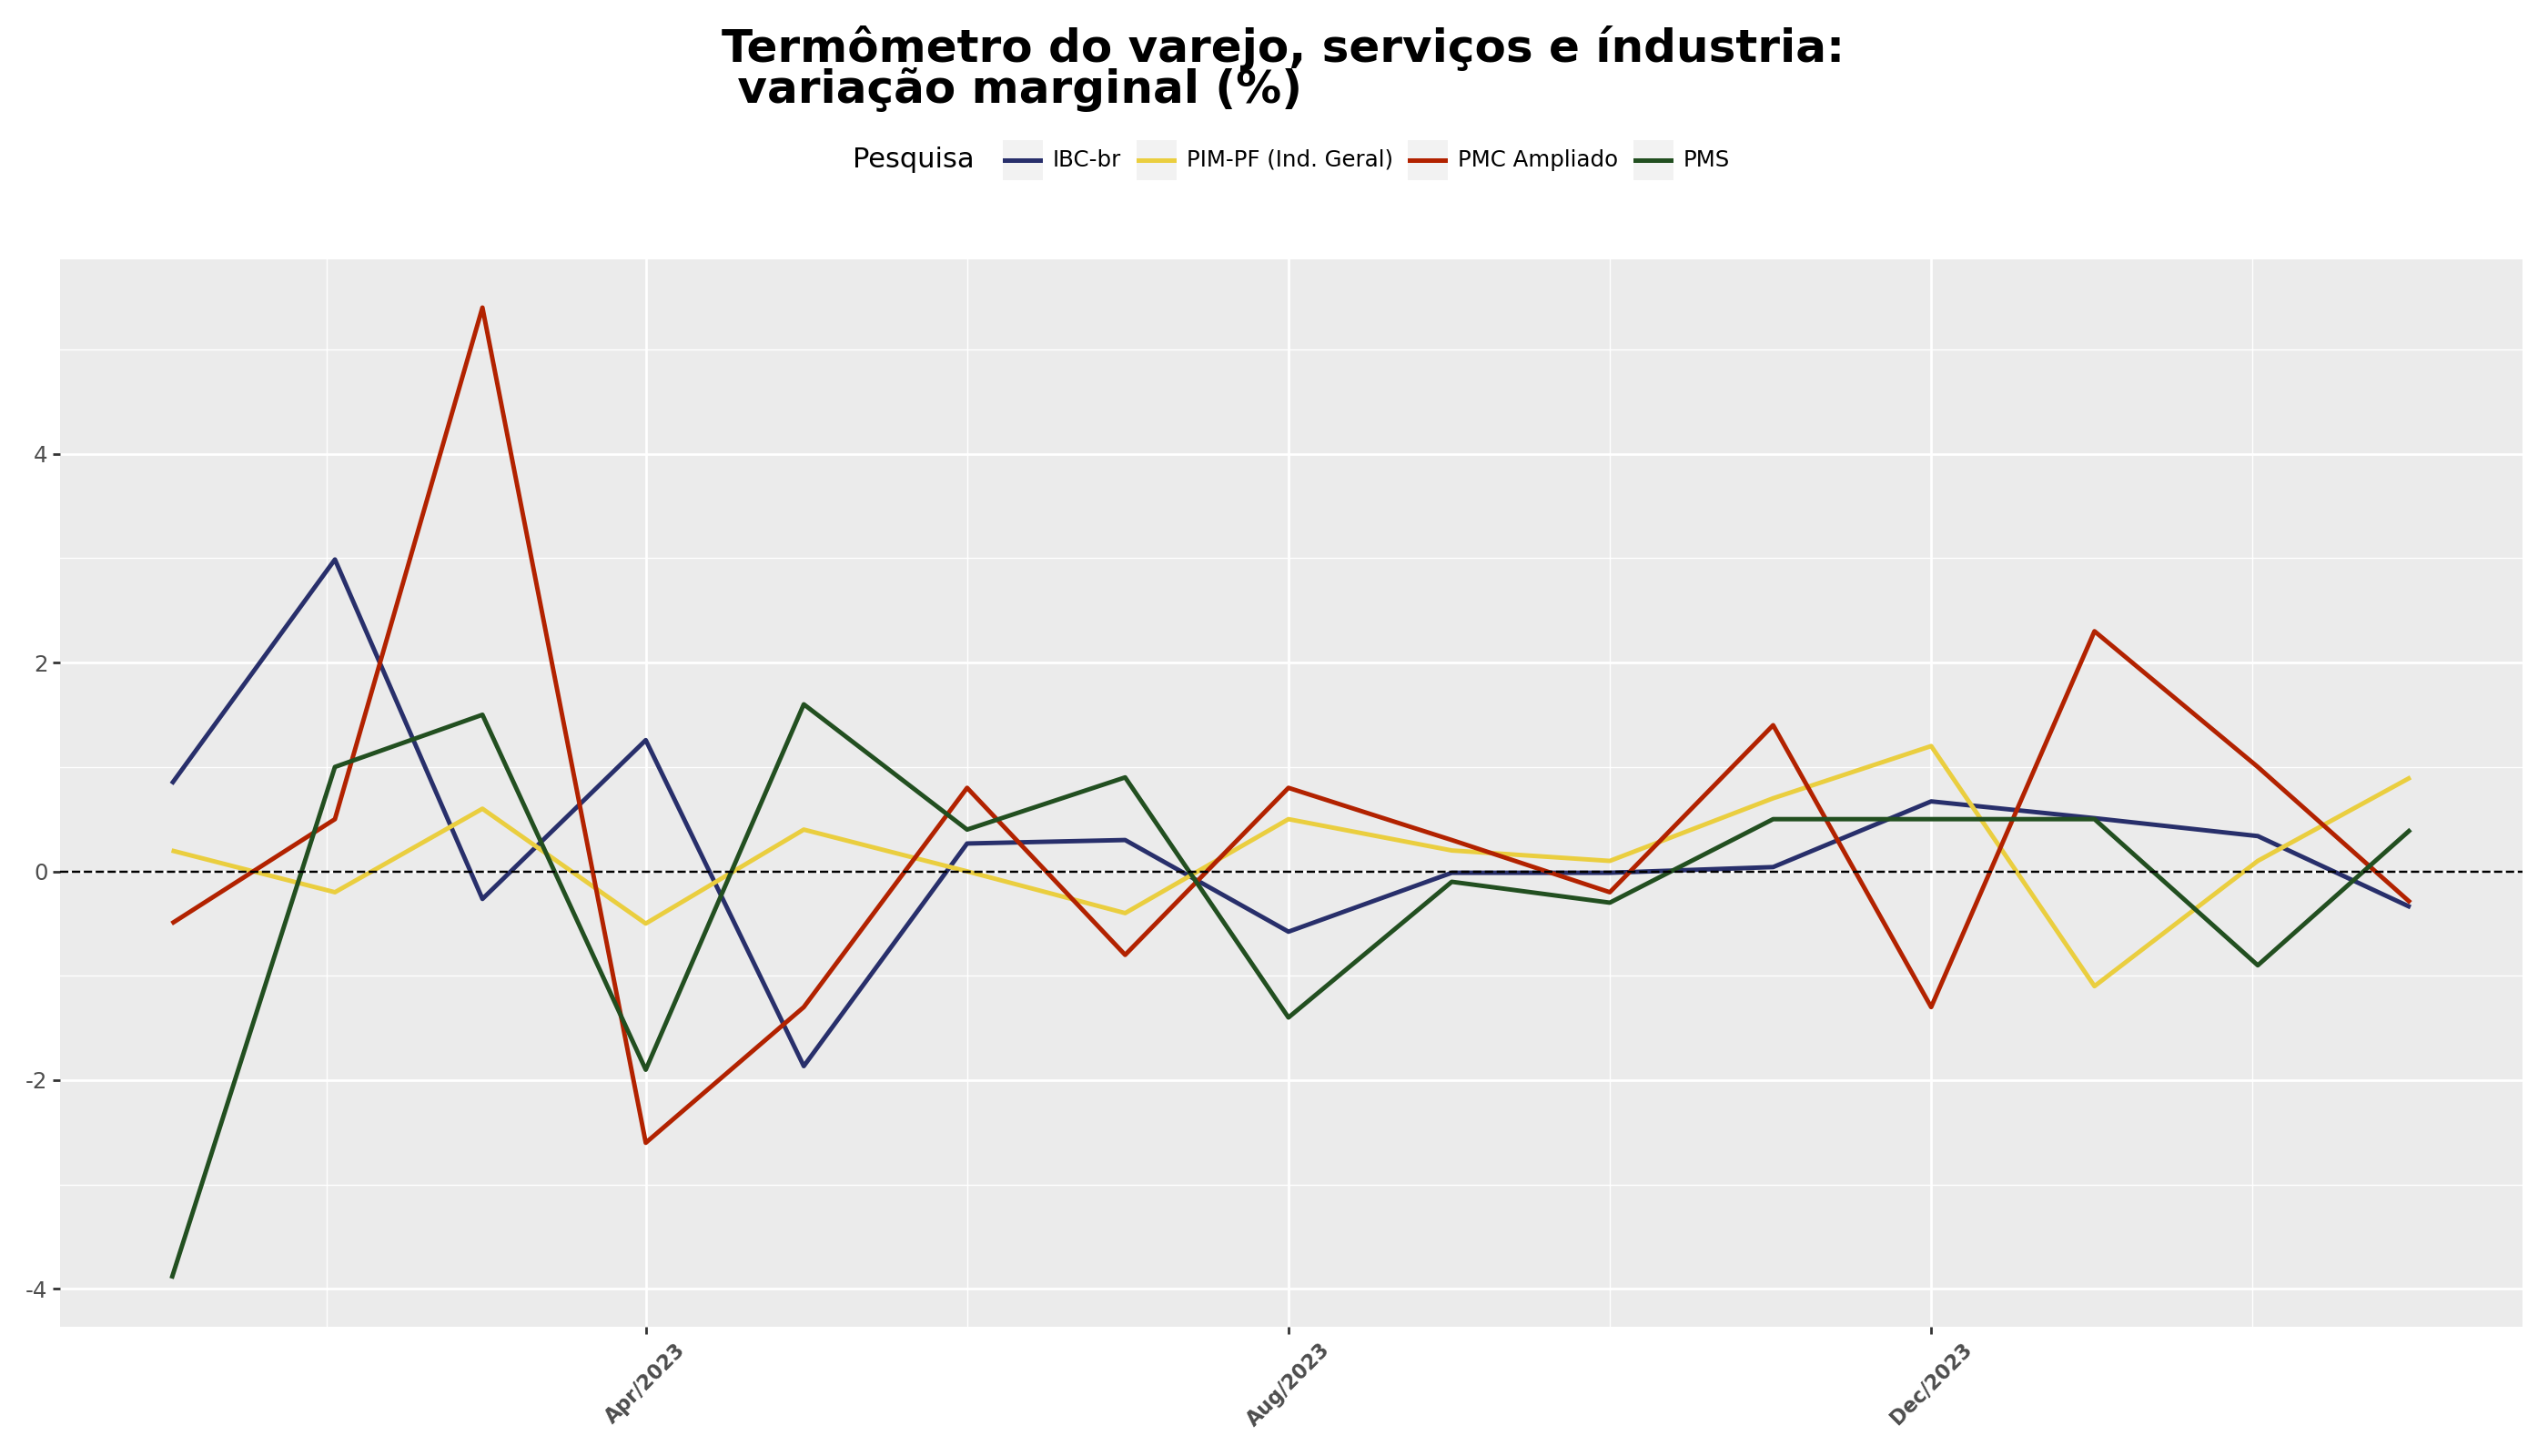

In [34]:
graf_pesquisas(pesquisas, "Var. % margem", data = "2023-01-01", titulo = "Termômetro do varejo, serviços e índustria: \n variação marginal (%)")

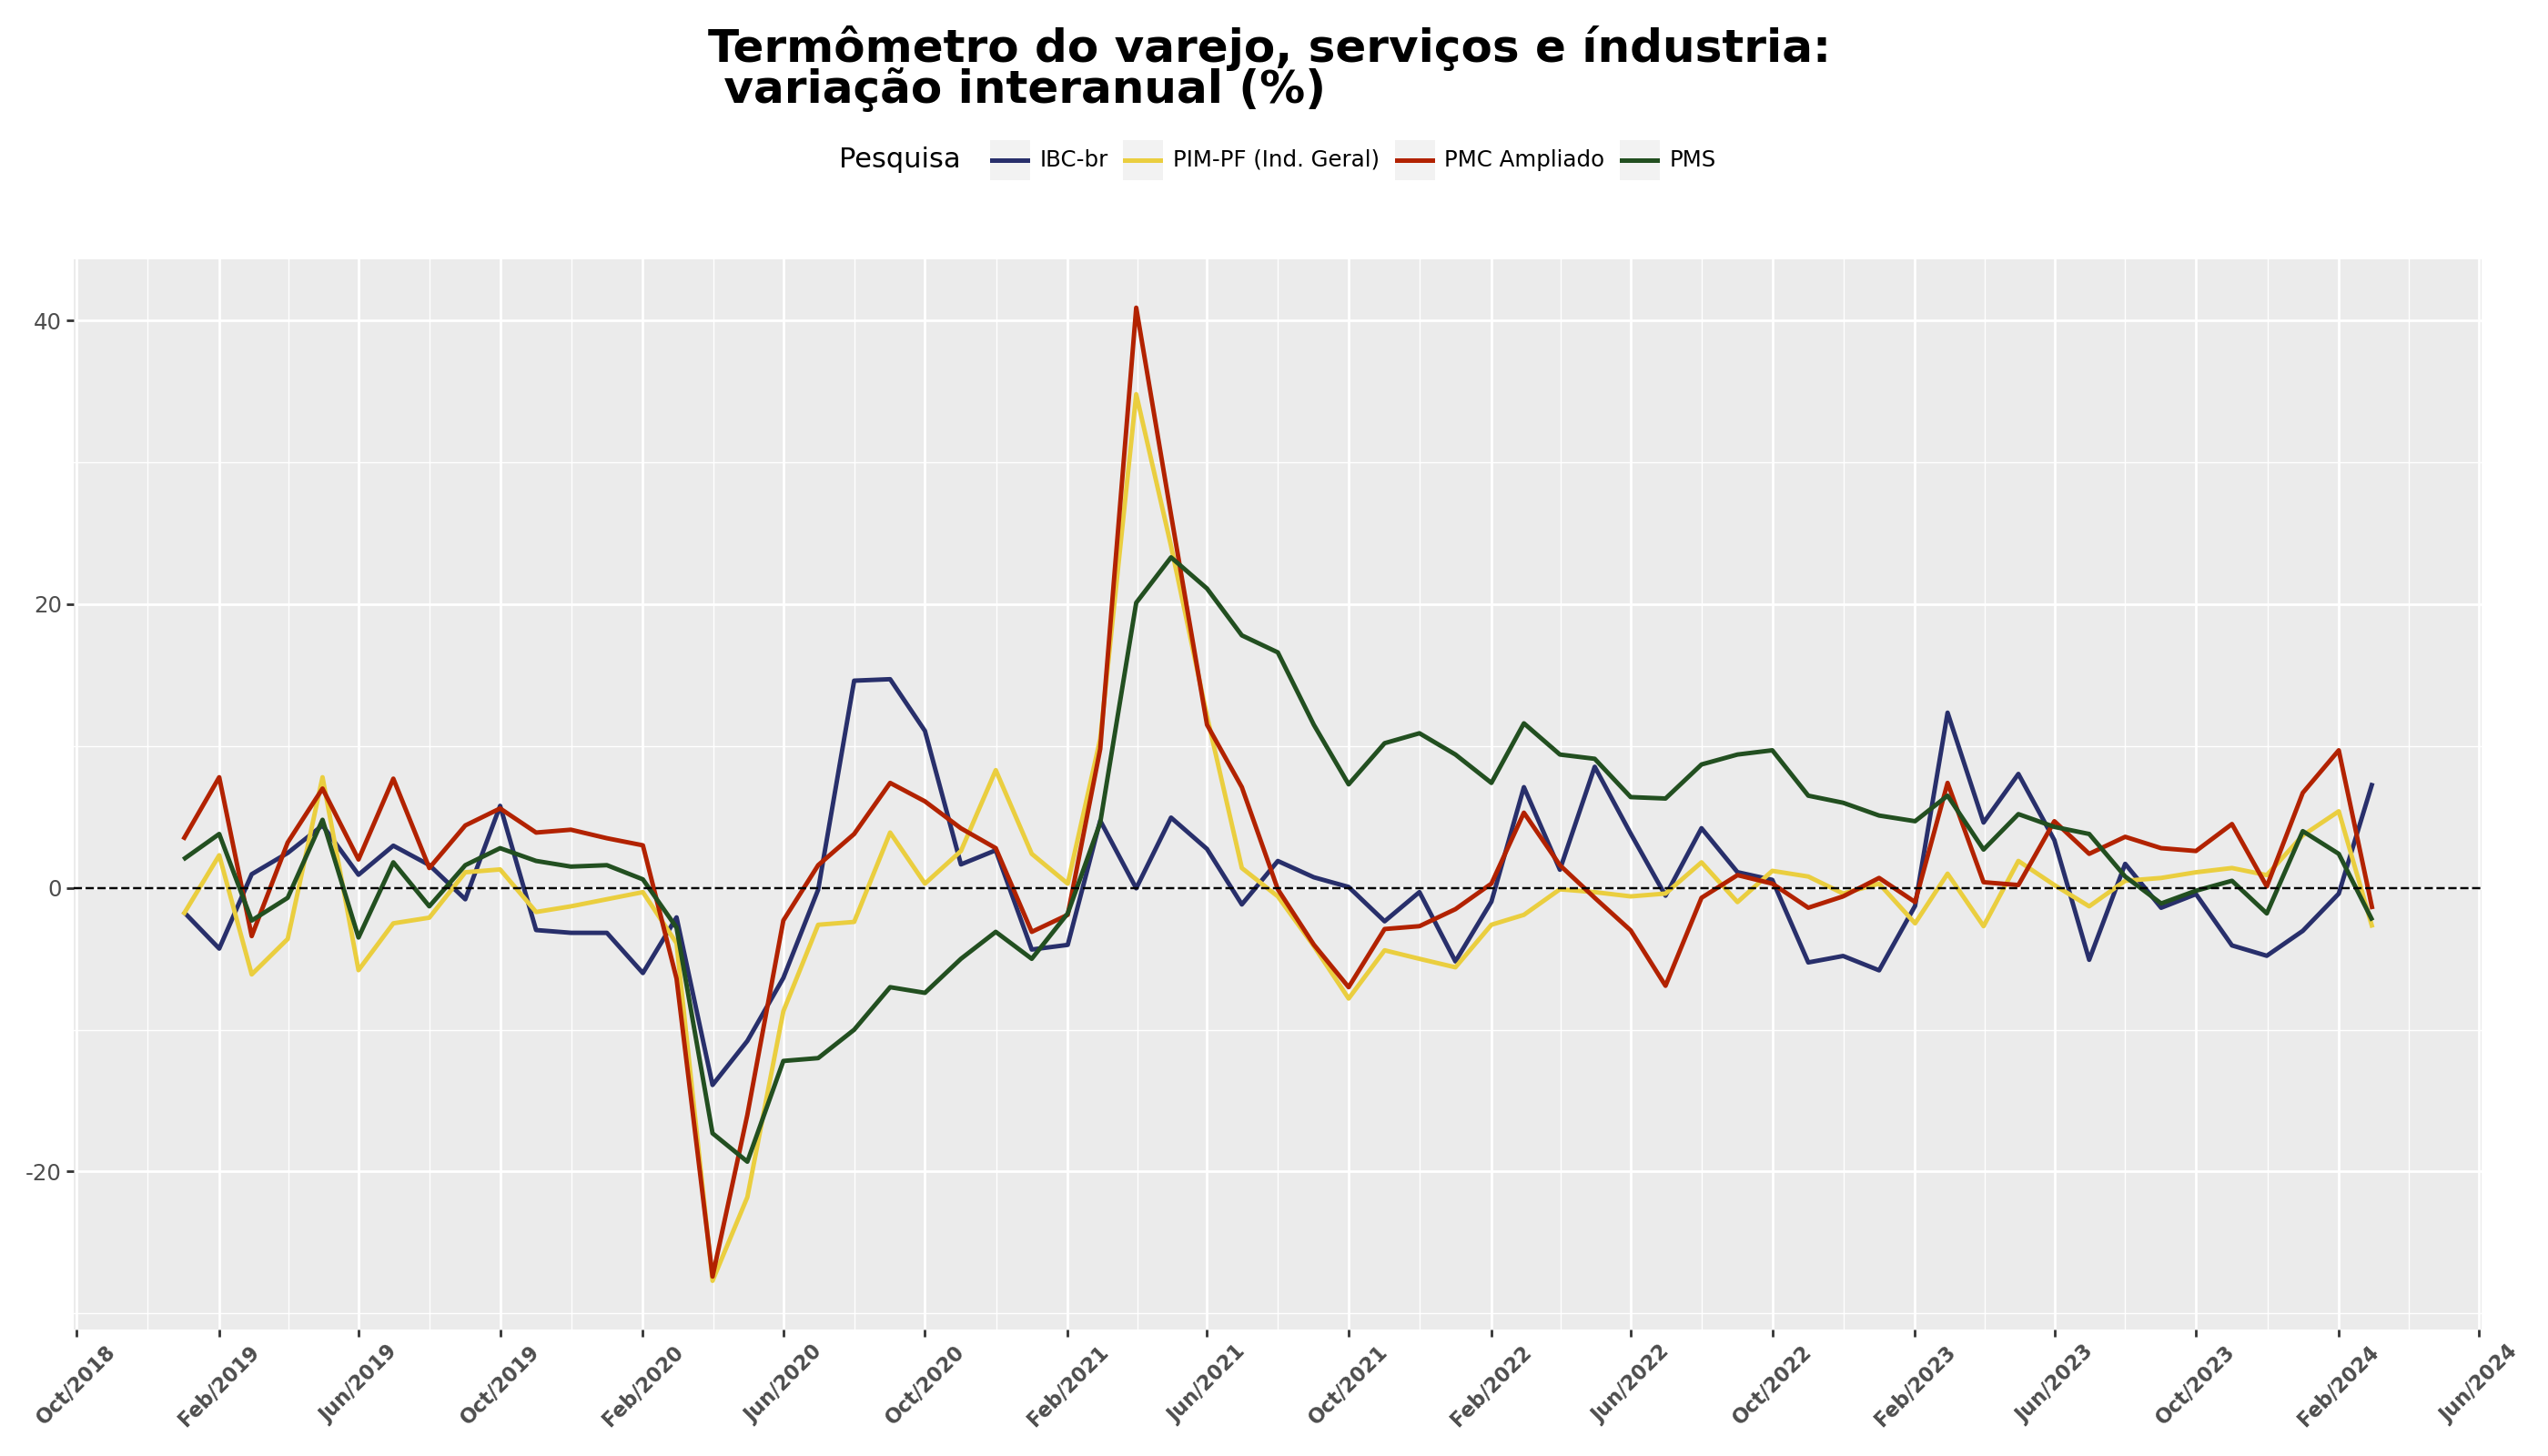

In [35]:
graf_pesquisas(pesquisas, "Var. % interanual", data = "2019-01-01", titulo = "Termômetro do varejo, serviços e índustria: \n variação interanual (%)")

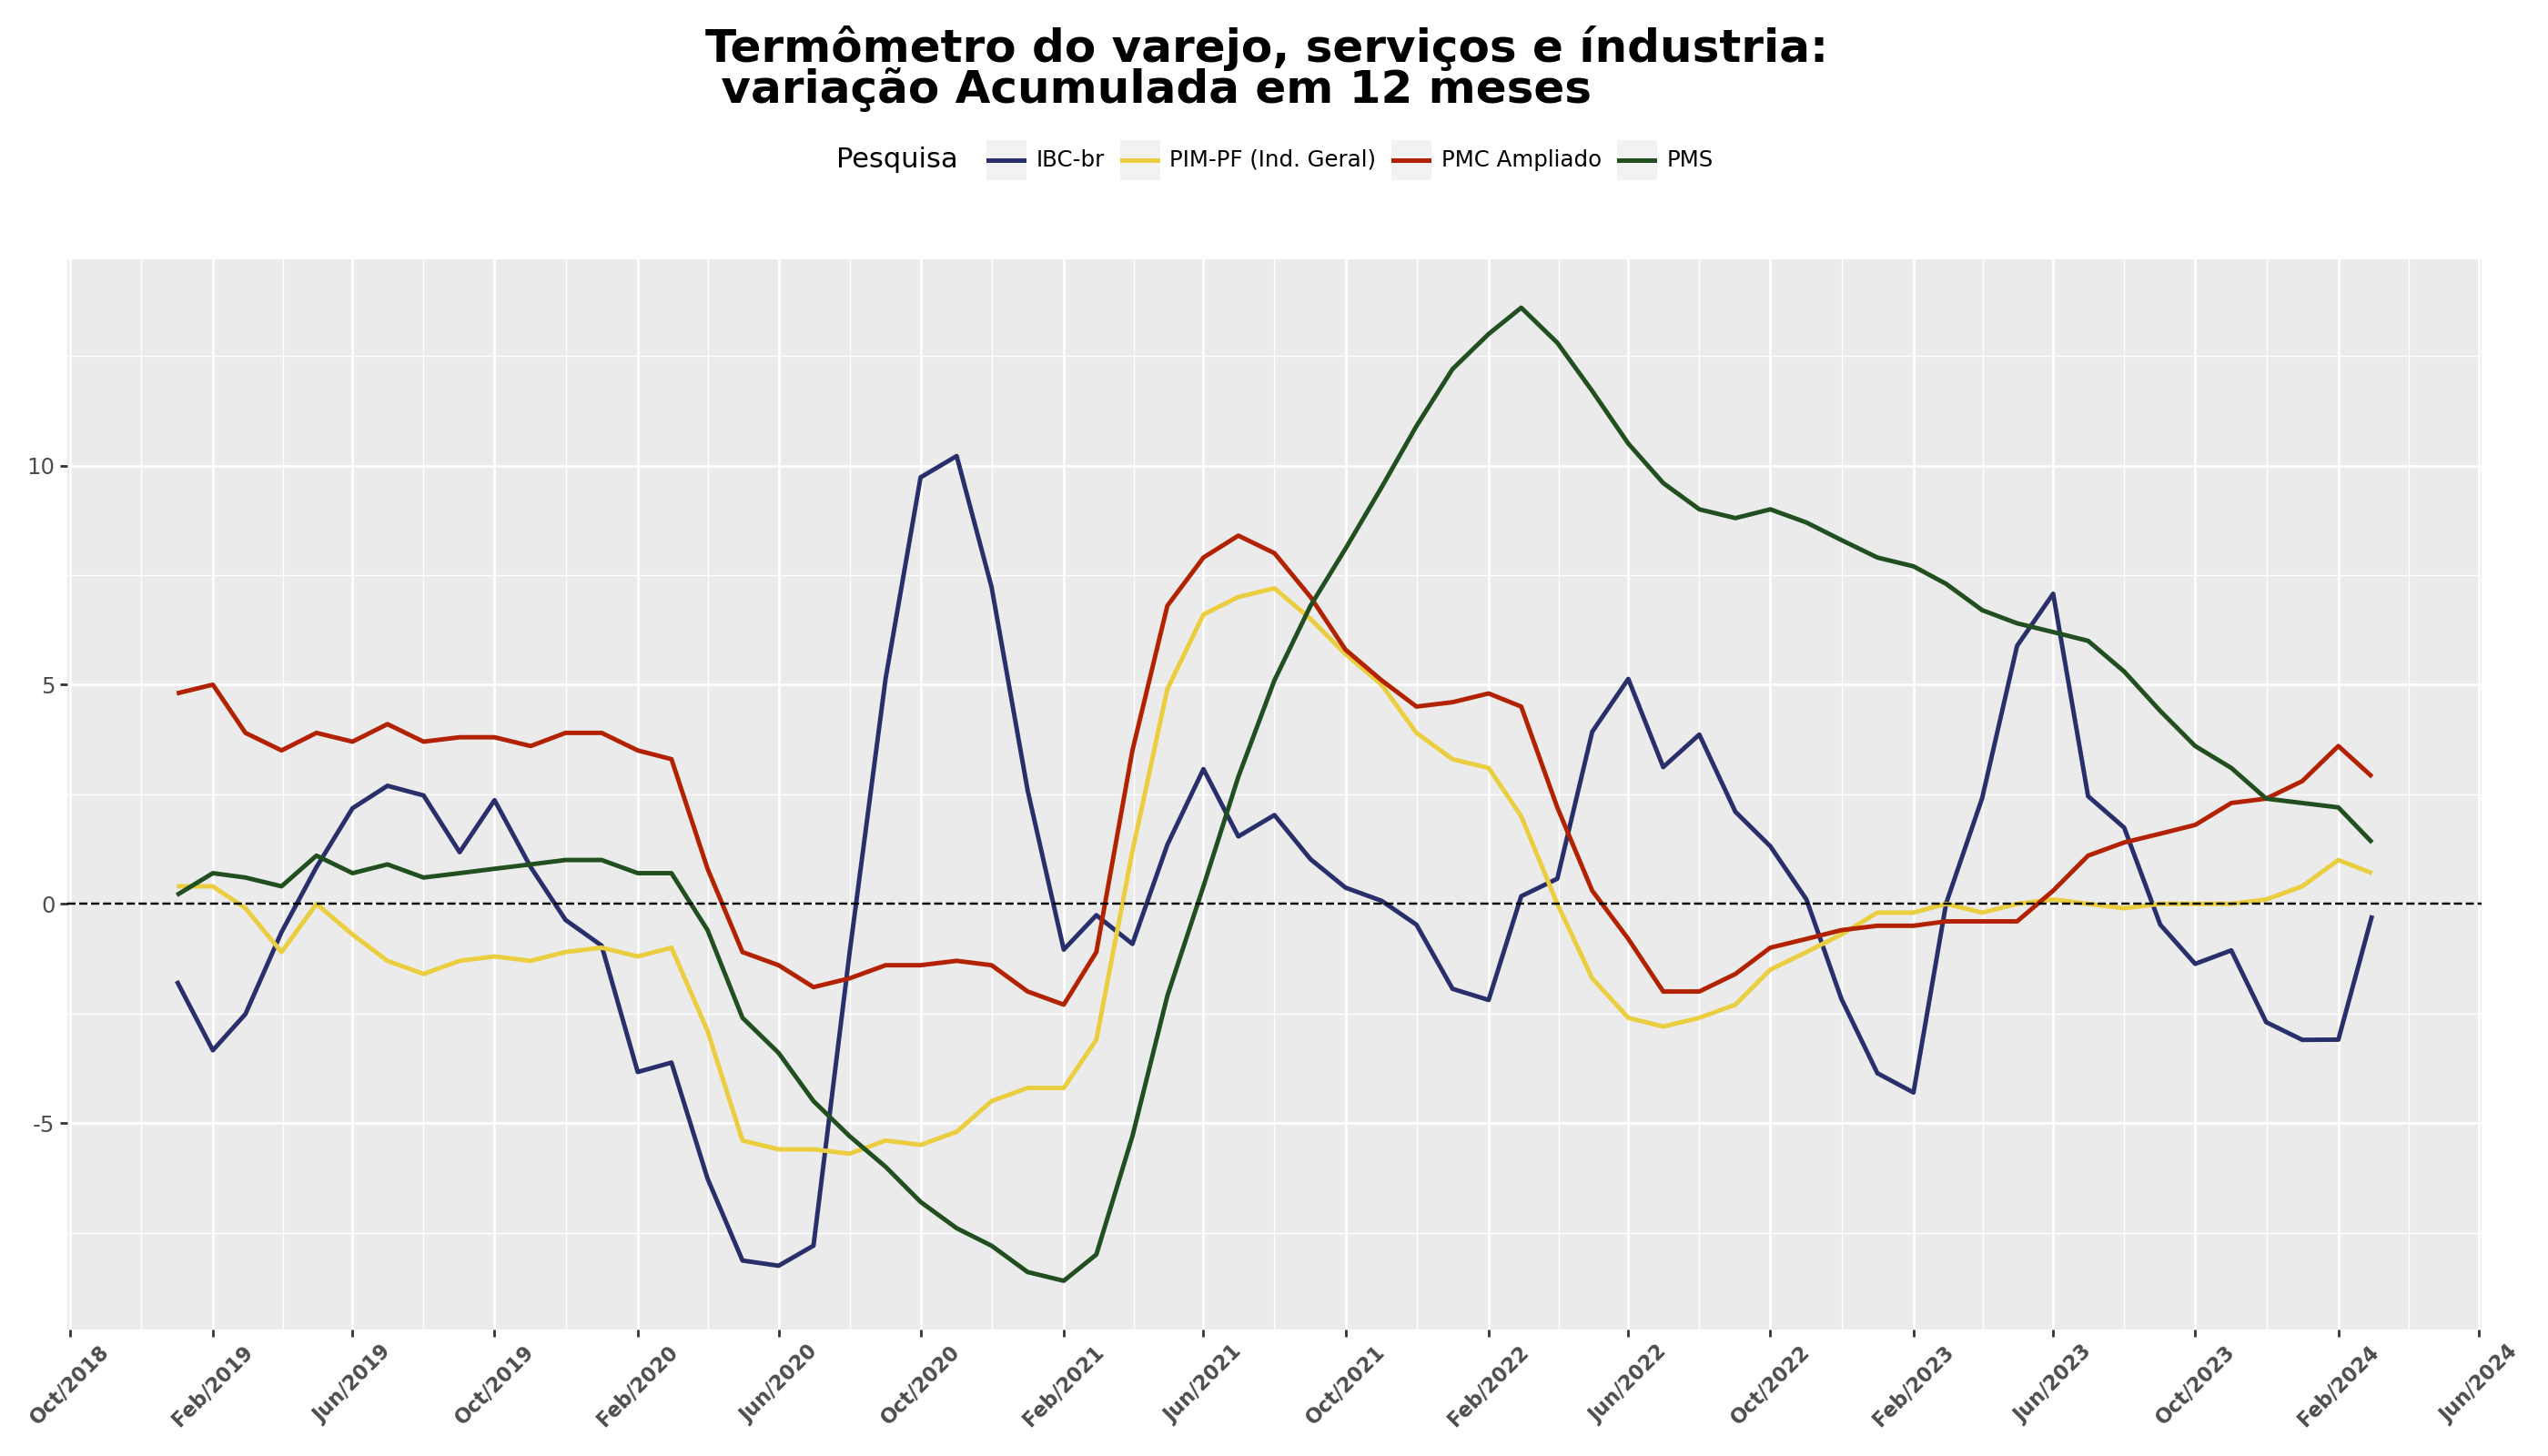

In [36]:
graf_pesquisas(pesquisas, "Var. % acumulada em 12 meses", data = "2019-01-01", titulo = "Termômetro do varejo, serviços e índustria: \n variação Acumulada em 12 meses")

C:\Users\pedro\AppData\Local\Temp\ipykernel_38828\1403597294.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


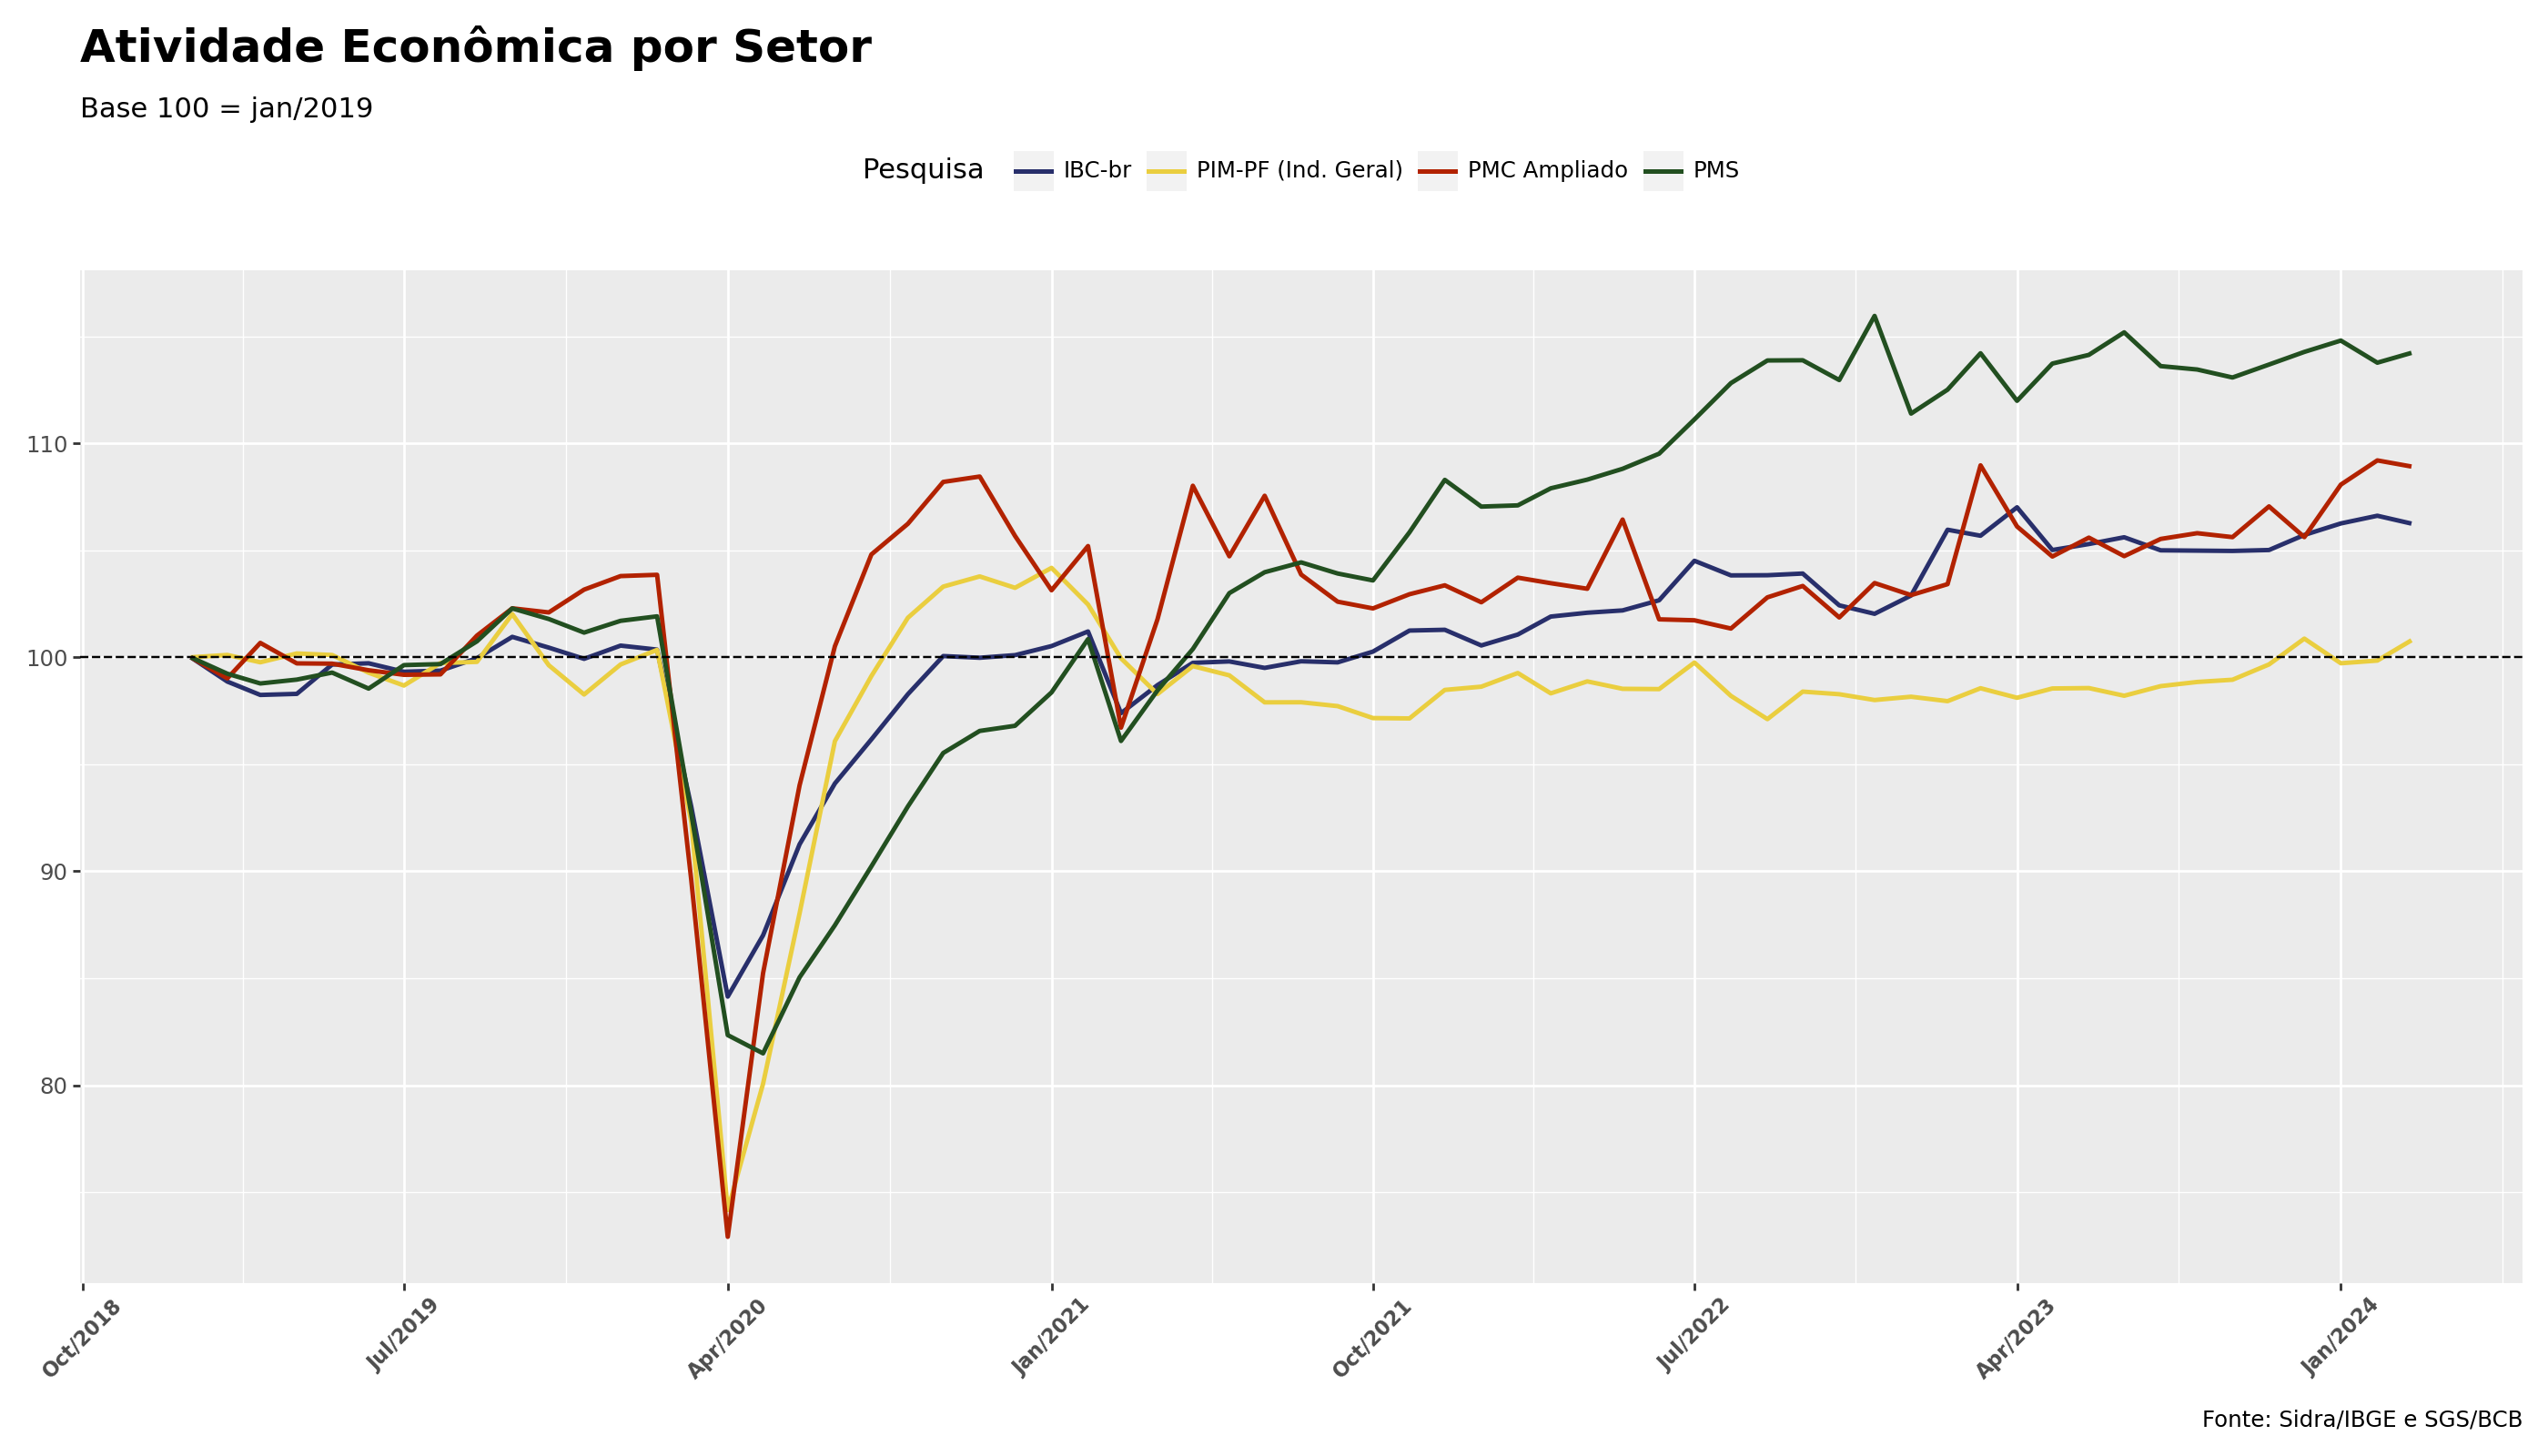

In [37]:
# Realiza a filtragem dos valores
filtro = pesquisas.query("variable == 'Número Índice S.A.' & data >= '2019-01-01'")

# Defina a data de referência para a transformação de base 100
data_referencia = '2019-01-01'

# Realiza a transformação de base 100 para cada indicador usando groupby
filtro['valor_base100'] = filtro.groupby('Pesquisa').apply(lambda x: (x['valor'] / x.loc[x['data'] == data_referencia, 'valor'].iloc[0]) * 100).reset_index(level=0, drop=True)


# Cria o gráfico
(
    ggplot(filtro, aes(x='data', y='valor_base100', color='Pesquisa')) +
    geom_line(size=1) +
    scale_color_manual(values=list(colors.values())) +
    scale_x_date(date_breaks="9 month", date_labels="%b/%Y") +
    geom_hline(yintercept=100, color="black", linetype="dashed") +
    theme(
        legend_position="top",
        figure_size=(14, 8),
        plot_title=element_text(size=18, face="bold"),
        axis_text_x=element_text(size=8, face="bold", angle = 45),
    ) +
    labs(
        x="",
        y="",
        title='Atividade Econômica por Setor',
        subtitle= "Base 100 = jan/2019",
        caption= "Fonte: Sidra/IBGE e SGS/BCB"
    )
)